In [29]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Fitting functions

In [30]:
# Functions and Definitions for Data fitting

COP_DATA = []         
COP_POLY_COEFFS = np.array([])  
COP_POLY_DEGREE = 3   

HEAT_POLY_COEFFS = np.array([])  # will store polynomial coefficients
HEAT_POLY_DEGREE = 3             # adjust as needed

def generate_heat_fit(heat_dict):
    global HEAT_POLY_COEFFS

    if not heat_dict:
        raise ValueError("No heat data to fit.")

    # Sort by temperature
    temps, heat_vals = zip(*sorted(heat_dict.items()))
    
    # Fit polynomial
    HEAT_POLY_COEFFS = np.polyfit(temps, heat_vals, HEAT_POLY_DEGREE)


def get_heat_from_fit(T):
    if HEAT_POLY_COEFFS is None or len(HEAT_POLY_COEFFS) == 0:
        raise RuntimeError("Heat polynomial fit has not been generated.")
    
    return float(np.polyval(HEAT_POLY_COEFFS, T))


def print_heat_fit_equation():
    terms = [f"{coef:.6g} * T^{HEAT_POLY_DEGREE - i}" 
            for i, coef in enumerate(HEAT_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("Heat(T) ≈", equation)



def store_COP_data(param, T_si_in):
    cop_val = 1. / calc_COP(param)  # invert reciprocal COP
    COP_DATA.append((T_si_in, cop_val))
    return 1. / cop_val

def generate_COP_fit():
    global COP_POLY_COEFFS
    if not COP_DATA:
        raise ValueError("No COP data to fit.")
    COP_DATA.sort(key=lambda x: x[0])
    T_vals, cop_vals = zip(*COP_DATA)
    COP_POLY_COEFFS = np.polyfit(T_vals, cop_vals, COP_POLY_DEGREE)

def get_COP_from_fit(T_si_in):
    if COP_POLY_COEFFS is None or len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("COP polynomial fit has not been generated.")
    return float(np.polyval(COP_POLY_COEFFS, T_si_in))

def calc_COP(param): 
    hp_vals = HP(param)

    state1 = hp_vals["state1"]

    state3= hp_vals["state3"]

    state2= hp_vals["state2"]

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 

    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

def print_COP_fit_equation():
    if len(COP_POLY_COEFFS) == 0:
        raise RuntimeError("Fit not generated yet.")

    terms = [f"{coef:.6g} * T^{COP_POLY_DEGREE - i}" 
        for i, coef in enumerate(COP_POLY_COEFFS)]
    equation = " + ".join(terms)
    print("COP(T_si_in) ≈", equation)


### Reading in file with Heat and COP data for fitting

In [31]:
#read in textfile

def read_results_from_txt(filepath="heat_pump_results.txt"):
    results = {}
    current_dia = None
    current_fluid = None
    mode = None

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            if line.startswith("DIA="):
                parts = line.split(", ")
                current_dia = int(parts[0].split("=")[1])
                current_fluid = parts[1].split("=")[1]

                if current_dia not in results:
                    results[current_dia] = {}

                results[current_dia][current_fluid] = {
                    "COP_DATA": [],
                    "HEAT_DATA": {}
                }

            elif line == "COP_DATA:":
                mode = "COP_DATA"

            elif line == "HEAT_DATA:":
                mode = "HEAT_DATA"

            elif line == "END_ENTRY":
                mode = None
                current_dia = None
                current_fluid = None

            elif mode == "COP_DATA":
                T, cop = map(float, line.split(","))
                results[current_dia][current_fluid]["COP_DATA"].append((T, cop))

            elif mode == "HEAT_DATA":
                T, Q = map(float, line.split(","))
                results[current_dia][current_fluid]["HEAT_DATA"][T] = Q

    return results

In [32]:
results = read_results_from_txt("heat_pump_results.txt")

COP_DATA = []
HEAT_DATA = {}

COP_DATA = results[35]['DimethylEther']['COP_DATA']

HEAT_DATA = results[35]['DimethylEther']['HEAT_DATA']

In [33]:
generate_COP_fit() #generates fit for exactly these conditions: power, diameter, refrigerant
generate_heat_fit(HEAT_DATA)

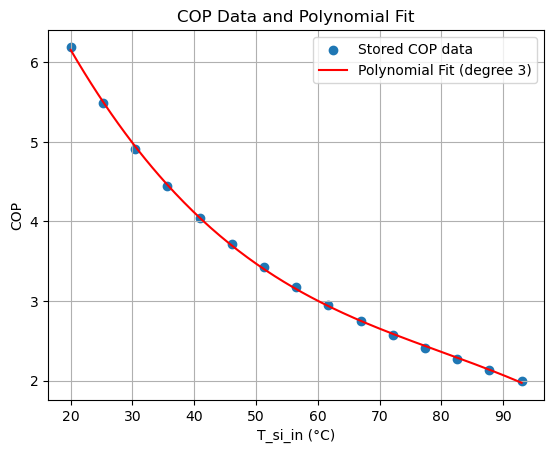

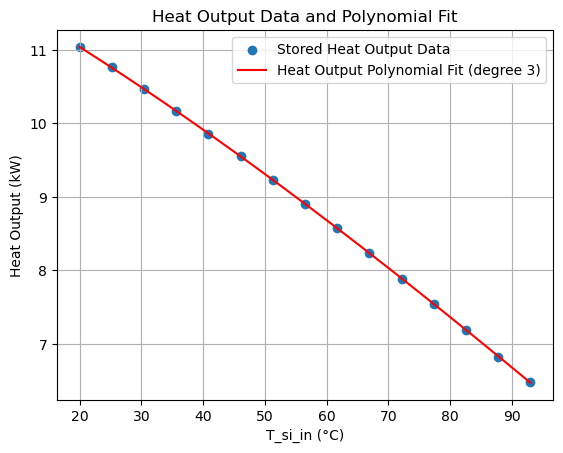

COP(T_si_in) ≈ -9.73764e-06 * T^3 + 0.00233583 * T^2 + -0.21498 * T^1 + 9.59538 * T^0
Heat(T) ≈ 4.24038e-07 * T^3 + -0.000183993 * T^2 + -0.0463586 * T^1 + 12.0357 * T^0


In [34]:
    # Plotting the data points and the fit
plt.scatter(*zip(*COP_DATA), label='Stored COP data')

T_plot = np.linspace(20,93, 200)
COP_fit_vals = [get_COP_from_fit(T) for T in T_plot]

plt.plot(T_plot, COP_fit_vals, 'r-', label='Polynomial Fit (degree {})'.format(COP_POLY_DEGREE))
plt.xlabel('T_si_in (°C)')
plt.ylabel('COP')
plt.title('COP Data and Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

#plotting heat output data
plt.scatter(*zip(*HEAT_DATA.items()), label='Stored Heat Output Data')
T_heat_plot = np.linspace(20, 93, 200)
heat_fit_vals = [get_heat_from_fit(T) for T in T_heat_plot]
plt.plot(T_heat_plot, heat_fit_vals, 'r-', label='Heat Output Polynomial Fit (degree {})'.format(HEAT_POLY_DEGREE))
plt.xlabel('T_si_in (°C)')
plt.ylabel('Heat Output (kW)')
plt.title('Heat Output Data and Polynomial Fit')
plt.legend()
plt.grid(True)
plt.show()

#print the equations for the fits

    
print_COP_fit_equation()
print_heat_fit_equation()

## Control Strategy with heat-up included

### Defining variables

In [35]:
# --- Global control variables ---
HP = 1  # initial state of the heat pump: 1 = ON, 0 = OFF
time = 0  # timer to record operating time

# --- Constants and parameters ---
R_env = 30 / 1000    # K/W
R_pasta = 15 / 1000  # K/W
c_l = 4.18 * 1000    # J/kg·K water
c_pasta = 3.5 * 1000 # J/kg·K pasta

T_env = 20      # °C
T_pasta_0 = 7        # °C
T_WP_on = 87.02  # °C
T_WP_off = 91.96    # °C
rho_water = 997.     # kg/m3

# --- Dimensions of the water tank ---
V_water = (47 - 0.4) * (27 - 0.4) * (20 - 0.2) / 1000# L
m_water = V_water / 1e3 * rho_water  # kg
m_pasta = 2 # kg

print(V_water)

24.543288000000004


### Defining pasta cooking schedule 

In [36]:
# --- Pasta batch schedule (7 min cook, 5 min break) ---
# could also be adapted if a new schedule was needed
def make_pasta_list(t):
    pasta_counter = 7 * 60
    break_counter = 5 * 60
    pasta_presence = np.zeros(len(t))
    
    for i in range(len(t)):
        if pasta_counter > 0:
            pasta_presence[i] = 1
            pasta_counter -= 1
        elif break_counter > 0:
            pasta_presence[i] = 0
            break_counter -= 1
        else:
            pasta_counter = 7 * 60 - 1
            break_counter = 5 * 60
            pasta_presence[i] = 1
    return pasta_presence

### Define heat pump control logic

In [37]:
# --- Heat pump control logic ---
def calc_HP(T, T_on, T_off, op_times):
    global HP, time

    # time counts how long the heat pump operates for one operation
    # HP signals if the heatpump is on or off

    # If Temperature falls below minimal threshold value --> turn heat pump on
    if T <= T_on: # Temperature is below T
        if HP == 0:
            time = 0
        HP = 1

    # If Temperature is above maximum threshold --> turn heat pump off
    elif T >= T_off:
        if HP == 1:
            op_times.append(time)
        HP = 0

    # If the Heatpump is on, increase operation time and calculate heat output for the respective sink temperature with the fit
    # Else output of the heatpump is zero at this timestel
    if HP == 1:
        time += 1
        return get_heat_from_fit(T) * 1000
    else:
        return 0

### Define Temperature ODE's for system

In [38]:
# --- ODE for water only ---
def temp_store_only_water(T_water, t, Q_WP, m_water, c_water):
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env) / (m_water * c_water)
    return dT_waterdt

# --- ODE for water + pasta ---
def temp_store_with_pasta(T, t, Q_WP, m_water, m_pasta, c_water, c_pasta):
    T_water, T_pasta = T
    dT_waterdt = (Q_WP - (T_water - T_env) / R_env - (T_water - T_pasta) / R_pasta) / (m_water * c_water)
    dT_pastadt = ((T_water - T_pasta) / R_pasta) / (m_pasta * c_pasta)
    return [dT_waterdt, dT_pastadt]

### Define the main simulation

In [39]:
# --- Main simulation with morning heat-up ---
def T_water_and_pasta_with_heatup(T_WP_on, T_WP_off, V_water, duration_s, op_times, m_water, m_pasta):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0, dtype=float)
    Q_WPs = np.zeros(duration_s)
    #Q_pasta = np.zeros(duration_s)

    T0_water = T_env  # Start at room temp
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    binary_pasta = np.zeros(duration_s)
    
    pasta_schedule_started = False
    pasta_schedule_start_index = None

    for i in range(1, duration_s):
        if not pasta_schedule_started and T0_water >= T_WP_on:
            pasta_schedule_start_index = i
            binary_pasta[i:] = make_pasta_list(np.arange(duration_s - i))
            pasta_schedule_started = True

        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_water, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0

        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_water, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta
        #Q_pasta[i] = m_pasta*c_pasta*(T_pasta[i] - T_pasta[i-1])

    return t, Q_WPs, T_water, T_pasta, pasta_schedule_start_index

### Running the simulation

#### Calculate additional time needed for heating up in the morning

In [40]:
# --- Step 1: Preliminary simulation to find heating-up time only ---
prelim_duration = 3 * 60 * 60  # simulate up to 3 hours for safety
op_times_prelim = []

# Run preliminary sim just to get heat-up time
_, _, T_water_prelim, _, prelim_start_index,  = T_water_and_pasta_with_heatup(
    T_WP_on, T_WP_off, V_water, prelim_duration, op_times_prelim, m_water, m_pasta)

if prelim_start_index is None:
    raise RuntimeError("Cooking schedule never started. Increase preliminary duration or check parameters.")

heating_up_time = prelim_start_index  # in seconds
print("Calculated heating-up time =", heating_up_time / 60, "minutes")

Calculated heating-up time = 15.316666666666666 minutes


#### Run simulation for the 12 hours of operation including the heating up time in the morning

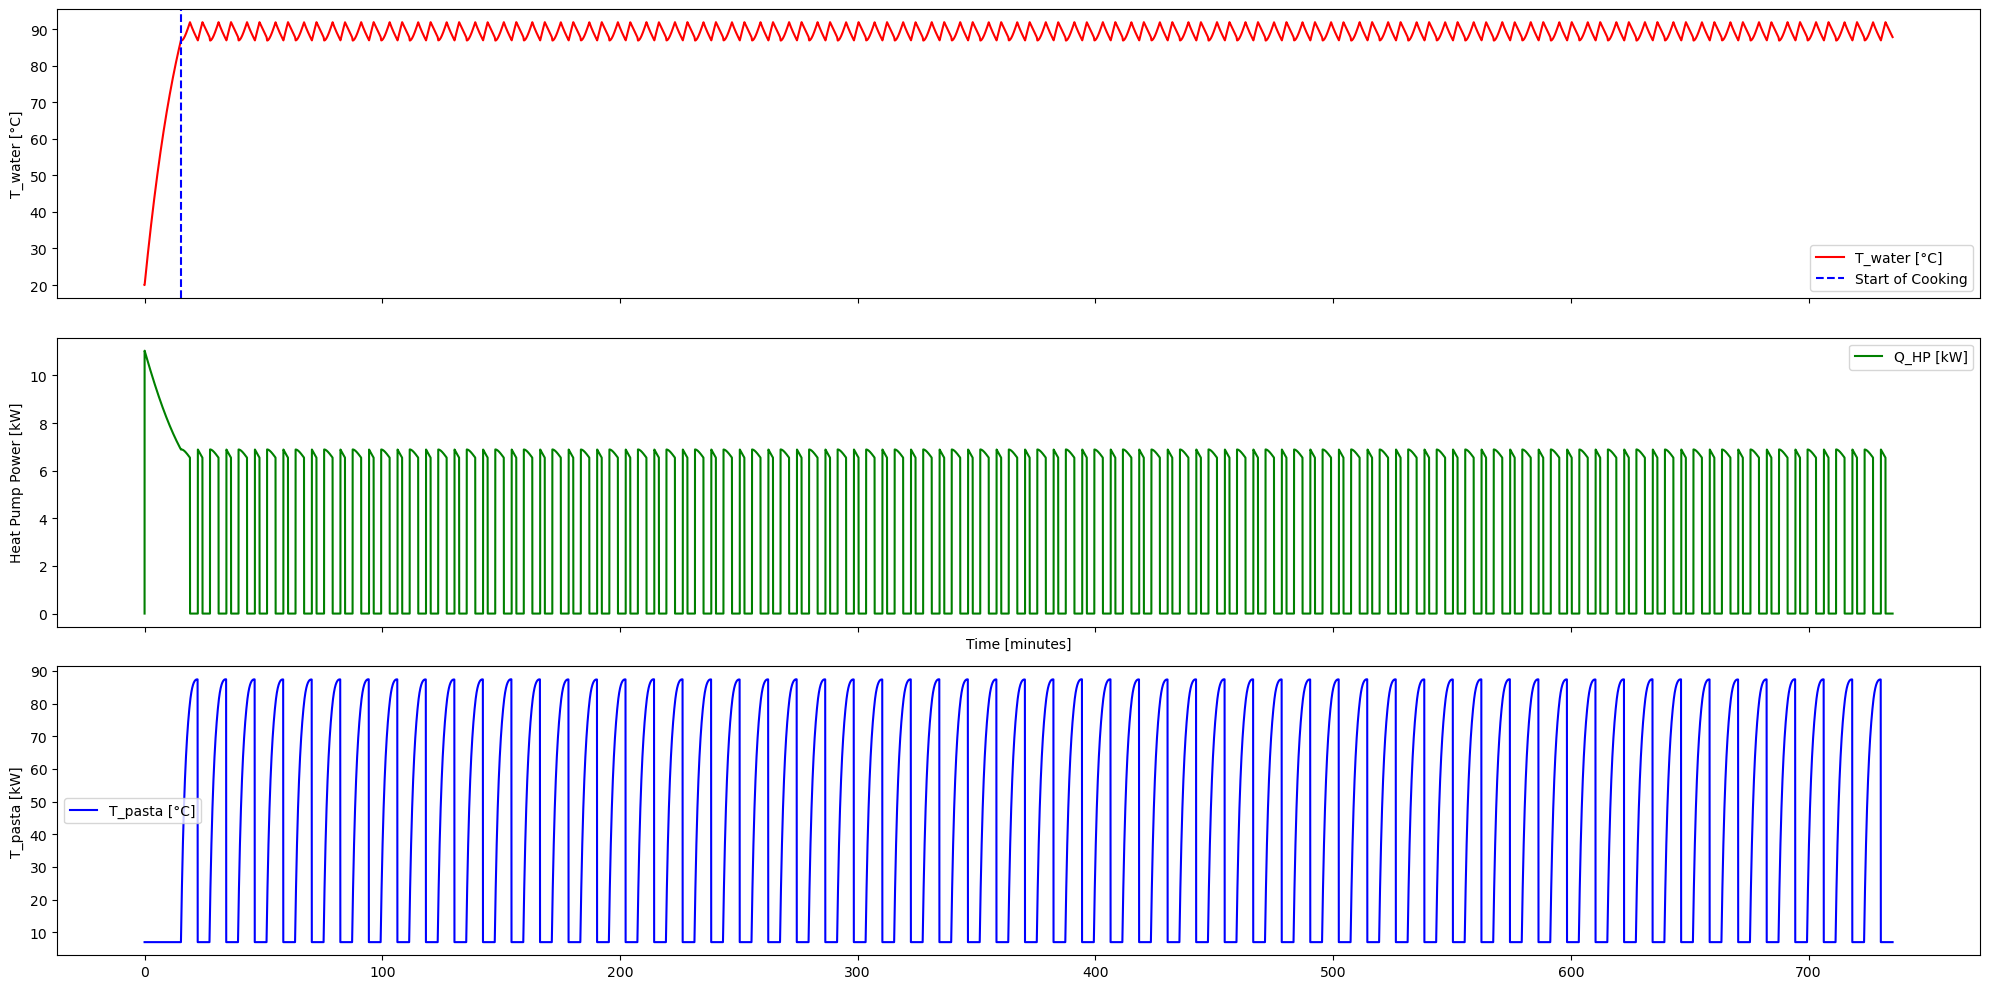

Time until cooking starts (heat-up) = 15.32 minutes
Min operating time = 1.92 minutes
Max operating time = 20.68 minutes
Number of heat pump on-cycles = 120
total_duration = 12.25527777777778 hours
92.00053477412649
86.9559170559667


In [41]:
duration_seconds = heating_up_time + 12 * 60 * 60  # 12 hours
op_times = []
t, Q_WPs, T_water, T_pasta, start_index = T_water_and_pasta_with_heatup(
    T_WP_on, T_WP_off, V_water, duration_seconds, op_times, m_water,m_pasta)

# --- Plot results ---
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20, 10))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
if start_index:
    ax1.axvline(t[start_index] / 60, color='blue', linestyle='--', label='Start of Cooking')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
ax3.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
ax3.set_ylabel('T_pasta [kW]')
ax3.legend()

"""
ax4.plot(t / 60, Q_pasta / 1000, 'g-', label='Q_HP [kW]')
ax4.set_xlabel('Time [minutes]')
ax4.set_ylabel('Heat Pump Power [kW]')
ax4.legend()
"""

plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)
heatup_time_min = round(t[start_index] / 60, 2) if start_index else "N/A"
total_duration = duration_seconds / 60 / 60 

print("Time until cooking starts (heat-up) =", heatup_time_min, "minutes")
print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)
print("total_duration =", total_duration, "hours")
print(max(T_water[heating_up_time:]))
print(min(T_water[heating_up_time:]))

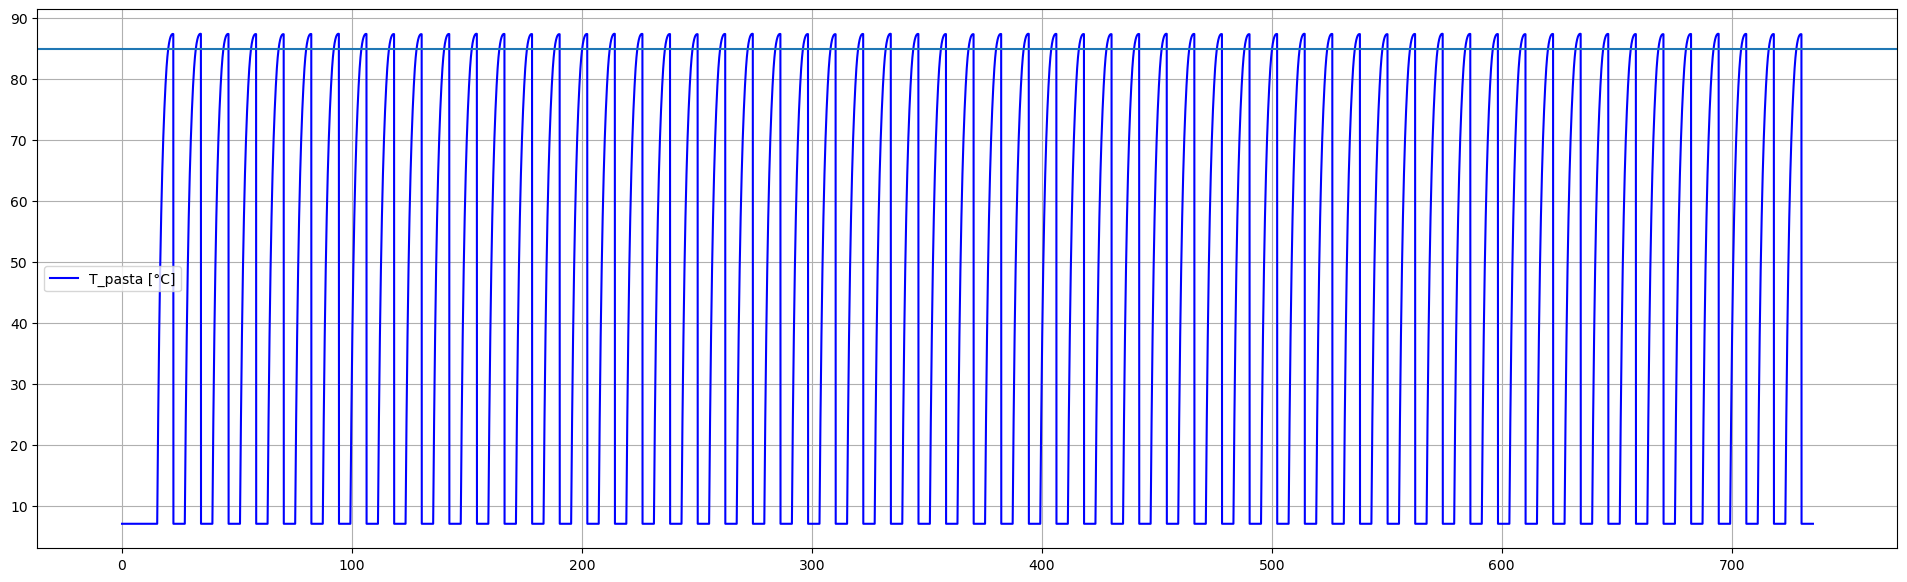

87.43275432181983
92.00053477412649
86.9559170559667


In [43]:
plt.figure(figsize=(24,7))
plt.plot(t / 60, T_pasta, 'b-', label='T_pasta [°C]')
plt.axhline(y=85)
plt.legend()
plt.grid(True)
plt.show()

print(max(list(T_pasta)))

print(max(list(T_water)))
print(min(list(T_water[60*104:])))

## Control strategy without heat-up

In [1]:
# --- Main simulation ---
def T_water_and_pasta(T_WP_on, T_WP_off, V_store, duration_s, op_times):
    t = np.linspace(0, duration_s, duration_s)
    T_water = np.zeros(duration_s)
    T_pasta = np.full(duration_s, T_pasta_0)
    Q_WPs = np.zeros(duration_s)

    T0_water = T_WP_on
    T0_pasta = T_pasta_0
    T_water[0] = T0_water
    T_pasta[0] = T0_pasta

    m_store = V_store / 1e3 * rho_water
    m_pasta = 2  # kg

    binary_pasta = make_pasta_list(t)

    global WP, time
    WP = 1
    time = 0

    for i in range(1, duration_s):
        if binary_pasta[i] == 0:
            tspan = [t[i - 1], t[i]]
            z = odeint(temp_store_only_water, T0_water, tspan, args=(Q_WPs[i - 1], m_store, c_l))
            T0_water = z[1][0]
            T0_pasta = T_pasta_0
        else:
            tspan = np.linspace(t[i - 1], t[i], 10)
            T_function = [T0_water, T0_pasta]
            sol = odeint(temp_store_with_pasta, T_function, tspan, args=(Q_WPs[i - 1], m_store, m_pasta, c_l, c_pasta))
            T0_water = sol[-1, 0]
            T0_pasta = sol[-1, 1]

        Q_WPs[i] = calc_HP(T0_water, T_WP_on, T_WP_off, op_times)
        T_water[i] = T0_water
        T_pasta[i] = T0_pasta

    return t, Q_WPs, T_water, T_pasta


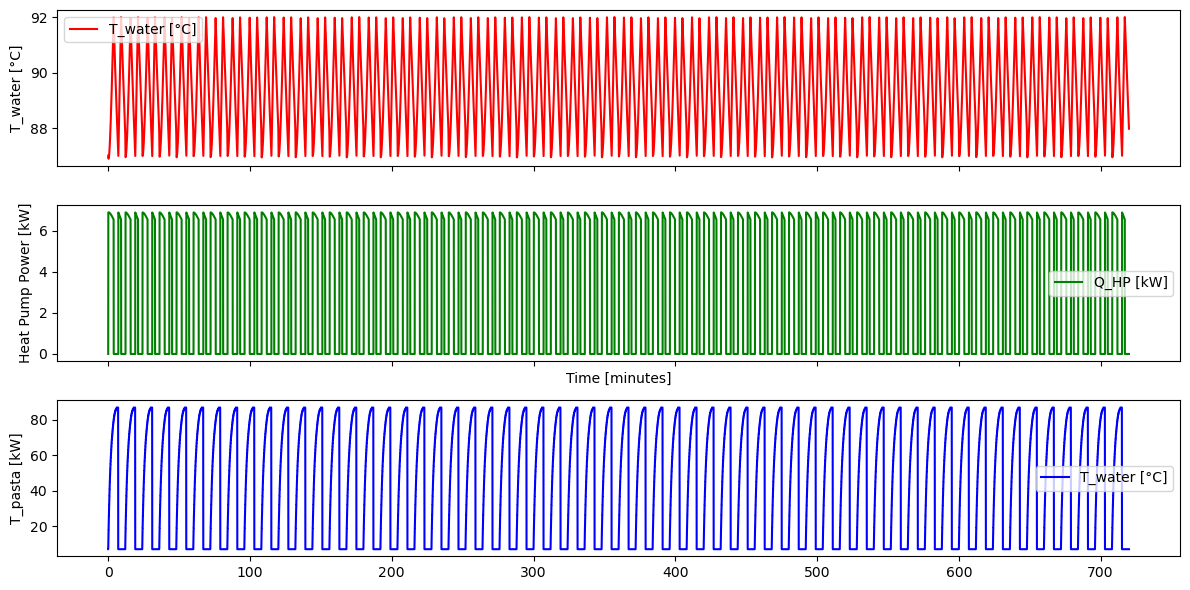

Min operating time = 1.92 minutes
Max operating time = 3.82 minutes
Number of heat pump on-cycles = 120


In [44]:
# --- Run simulation ---
duration_seconds = 12 * 60 * 60  # 12 hours
op_times = []
t, Q_WPs, T_water, T_pasta = T_water_and_pasta(T_WP_on, T_WP_off, V_water, duration_seconds, op_times)

# --- Plot results ---
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12, 6))
ax1.plot(t / 60, T_water, 'r-', label='T_water [°C]')
ax1.set_ylabel('T_water [°C]')
ax1.legend()
ax2.plot(t / 60, Q_WPs / 1000, 'g-', label='Q_HP [kW]')
ax2.set_xlabel('Time [minutes]')
ax2.set_ylabel('Heat Pump Power [kW]')
ax2.legend()
ax3.plot(t / 60, T_pasta, 'b-', label='T_water [°C]')
ax3.set_ylabel('T_pasta [kW]')
ax3.legend()
plt.tight_layout()
plt.show()

# --- Compute and show summary ---
min_op = round(min(op_times) / 60., 2) if op_times else 0
max_op = round(max(op_times) / 60., 2) if op_times else 0
num_cycles = len(op_times)

print("Min operating time =", min_op, "minutes")
print("Max operating time =", max_op, "minutes")
print("Number of heat pump on-cycles =", num_cycles)
